<a href="https://colab.research.google.com/github/manhcuong02/Pets-semantic-segmentation/blob/main/pets_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install torchmetrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dog and cat segmentation dataset

In [3]:
%cd /content/drive/MyDrive/Colab/Semantic_Segmentation
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

/content/drive/MyDrive/Colab/Semantic_Segmentation
--2023-06-06 02:44:30--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-06-06 02:44:30--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  51.2MB/s    in 15s     

2023-06-06 02:44:45 (51.0 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-06-06 02:44:45--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.u

In [4]:
%cd /content/drive/MyDrive/Colab/Semantic_Segmentation
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

/content/drive/MyDrive/Colab/Semantic_Segmentation


# Import library

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os 
import torch
import segmentation_models_pytorch as smp # 
import torchmetrics
import albumentations as Aug # augmentation 

from albumentations.pytorch import ToTensorV2
from torchmetrics import Dice, JaccardIndex # Dice, IoU
from tqdm import tqdm
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from glob import glob
import random

In [6]:
torch.cuda.is_available()

True

# Định nghĩa Dataset

In [7]:
class DogCatDataset(Dataset):
    def __init__(self, image_dir,annotation_dir, txt_file_path, transform = None):
        super().__init__()

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.txt_file_path = txt_file_path
        self.transform = transform

        self.image_filename_list = []

        with open(txt_file_path, 'r') as file:
            for line in file.readlines():
                self.image_filename_list.append(line.split(' ')[0])

    def __len__(self):
        return len(self.image_filename_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, '{}.jpg'.format(self.image_filename_list[idx]))
        mask_path = os.path.join(self.annotation_dir, '{}.png'.format(self.image_filename_list[idx]))

        image = cv.imread(image_path)
        mask = cv.imread(mask_path, 0)
        mask[mask == 2] = 0
        mask[mask == 3] = 1
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        return image, mask

# UNet Model

In [8]:
def unet_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()        
        )

class UNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.down_sample = nn.MaxPool2d(kernel_size = 2)
        self.up_sample = nn.Upsample(scale_factor = 2, mode = 'bilinear')
        
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128) 
        self.block_down3 = unet_block(128, 256) 
        self.block_down4 = unet_block(256, 512)

        self.neck = unet_block(512, 1024)

        self.block_up1 = unet_block(1024 + 512, 512)
        self.block_up2 = unet_block(512 + 256, 256)
        self.block_up3 = unet_block(256 + 128, 128)
        self.block_up4 = unet_block(128 + 64, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size = 1, stride = 1)

    def forward(self, x):
        # x: batch_size, channels, height, width 
        x = self.block_down1(x)
        x1 = x.clone()

        x = self.down_sample(x)
        x = self.block_down2(x)
        x2 = x.clone()

        x = self.down_sample(x)
        x = self.block_down3(x)        
        x3 = x.clone()

        x = self.down_sample(x)
        x = self.block_down4(x)
        x4 = x.clone()

        x = self.down_sample(x)
        x = self.neck(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x4, x], dim = 1
        )
        x = self.block_up1(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x3, x], dim = 1
        )
        x = self.block_up2(x)

        x = self.up_sample(x)
        x = torch.cat(
            [x2, x], dim = 1
        )
        x = self.block_up3(x)
        
        x = self.up_sample(x)
        x = torch.cat(
            [x1, x], dim = 1
        )
        x = self.block_up4(x)

        x = self.out(x)
        return x

# Split dataloader

In [9]:
def split_dataloader(train_data, validation_split = 0.2):
    # Chia DataLoader thành phần train và test
    train_ratio = 1 - validation_split  # Tỷ lệ phần train (80%)
    train_size = int(train_ratio * len(train_data.dataset))  # Số lượng mẫu dùng cho train

    indices = list(range(len(train_data.dataset)))  # Danh sách các chỉ số của dataset
    train_indices = indices[:train_size]  # Chỉ số của mẫu dùng cho train
    val_indices = indices[train_size:]  # Chỉ số của mẫu dùng cho test

    # lấy dữ liệu từ dataloader
    dataset = train_data.dataset
    batch_size = train_data.batch_size
    num_workers = train_data.num_workers
    
    # Tạo ra các SubsetRandomSampler để chọn một phần dữ liệu cho train và test
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Tạo DataLoader mới từ SubsetRandomSampler
    train_data = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers, drop_last = True)
    val_data = DataLoader(dataset, batch_size = batch_size, sampler = val_sampler, num_workers = num_workers, drop_last = True)
    
    return train_data, val_data


# Evaluate function

In [10]:
def evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = 'cpu', weights = None):
    # set device
    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    model = model.to(device)
    dice_fn = dice_fn.to(device)    
    iou_fn = iou_fn.to(device)
    with torch.no_grad():
        model.eval()
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.
        val_total = len(val_data) * val_data.batch_size
        for x, y in val_data:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            y_hat = y_hat.squeeze() # [batch, 1, h, w] -> [batch, h, w]
            loss = loss_fn(y_hat, y.float())
            
            running_loss += loss.item()

            # accuracy && iou && dice
            y_hat = F.sigmoid(y_hat).round().long()
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

        val_loss = running_loss / len(val_data)
        val_accuracy = accuracy / val_total
        val_dice_score = dice_score / len(val_data)
        val_iou_score = iou_score / len(val_data) 
        return val_loss, val_accuracy, val_dice_score, val_iou_score


# Train function

In [11]:
def train(model, train_data, loss_fn, optimizer, dice_fn, iou_fn, device = 'cpu', weights = None, num_epochs = 50, steps_per_epoch = None,
          validation_data = None, validation_split = None, save_last_weights = None):
    
    # đặt validation_data and validation_split không đồng thời khác None
    assert not(validation_data is not None and validation_split is not None)

    if isinstance(device, str):
        if (device == 'cuda' or device == 'gpu') and torch.cuda.is_available():
            device = torch.device(device)
        else:
            device = torch.device('cpu')

    if weights:
        model.load_state_dict(torch.load(weights))
        print('Weights loaded successfully from path:', weights)
        print('====================================================')

    # chia dữ liệu thành 2 tập train và val    
    if validation_data is not None:
        val_data = validation_data
    elif validation_split is not None: 
        train_data, val_data = split_dataloader(train_data, validation_split)
    else: 
        val_data = None 

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)

    # 
    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1
    batch_size = train_data.batch_size

    # add model to device
    model = model.to(device)
    dice_fn = dice_fn.to(device)
    iou_fn = iou_fn.to(device)

    # history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }

    for epoch in range(1, num_epochs + 1):
        accuracy = 0
        dice_score = 0
        iou_score = 0
        running_loss = 0.

        train_total = steps_per_epoch * train_data.batch_size

        model.train()
        for step in tqdm(range(steps_per_epoch), desc = f'Epoch {epoch}/{num_epochs}: ', ncols = 100):
            x, y = next(iterator)
            x, y = x.to(device), y.to(device)

            y_hat = model(x)
            y_hat = y_hat.squeeze()
            loss = loss_fn(y_hat, y.float())

            # xóa gradient lần tính trước đó
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            # accuracy && iou && dice
            y_hat = F.sigmoid(y_hat).round().long()
            accuracy  += torch.sum(y == y_hat) / y_hat.flatten(start_dim = 1).shape[1]
            dice_score += dice_fn(y_hat, y.long())
            iou_score += iou_fn(y_hat, y.long())

            # nếu nó duyệt hết qua tập dữ liệu thì cho nó lặp lại 1 lần nữa
            if count_steps == num_steps:
                iterator = iter(train_data)
                count_steps = 0
            count_steps += 1
        train_loss = running_loss / steps_per_epoch
        train_accuracy = accuracy / train_total
        train_dice_score = dice_score / steps_per_epoch
        train_iou_score = iou_score / steps_per_epoch 

        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)

        print(f'Epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, train_iou_score: {train_iou_score: .2f}, train_dice_score: {train_dice_score: .2f}')
        if val_data:
            val_loss, val_accuracy, val_dice_score, val_iou_score = evaluate(model, val_data, loss_fn, dice_fn, iou_fn, device = device)
            history['val_acc'].append(val_accuracy)
            history['val_loss'].append(val_loss)
            
            print(f'Epoch: {epoch}, val_accuracy: {val_accuracy: .2f}, val_loss: {val_loss: .3f}, val_iou_score: {val_iou_score: .2f}, val_dice_score: {val_dice_score: .2f}')


    if save_last_weights:  
        torch.save(model.state_dict(), save_last_weights)
        print(f'Saved successfully last weights to:', save_last_weights)
    return model, history

# Predict class

In [78]:
class Prediction:
    def __init__(self, model, weights = None, img_size = 256, device = 'cpu'):
        
        # set device
        if isinstance(device, str):
            if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
                device = torch.device('cuda')
            else: 
                device = torch.device('cpu')
        
        self.model = model.to(device)
        if weights:
            self.model.load_state_dict(torch.load(weights))
        
        if isinstance(img_size, int):
            img_size = (img_size,img_size)
            
        self.img_size = img_size
    
    def transform(self, img):
        predict_transform = Aug.Compose(
            [
                Aug.Resize(height = self.img_size[0], width = self.img_size[1]),
                Aug.Normalize(),
                Aug.pytorch.ToTensorV2()
            ]
        )

        transformed_img = predict_transform(image = img)

        return transformed_img['image']

    def inverse_transform(self, img, img_size):
        if torch.is_tensor(img):
            img = img.numpy().astype(np.uint8)
        
        img = cv.resize(img, (img_size[1], img_size[0]))
        return img

    def predict(self, img, transform = True):
        # requires a numpy array image
        origin_shape = img.shape[:2]

        self.model.eval()

        # nếu ảnh chưa đi qua phép biến đổi để trở về với định dạng chuẩn của mạng thì sẽ được đi qua 1 lớp transform
        if transform:
            img = self.transform(img)
        if len(img.shape) == 3:
            img = img[None]
        
        img = img.to(device)

        predicted_mask = self.model(img)
        predicted_mask = F.sigmoid(predicted_mask).round().long()
        predicted_mask = predicted_mask.squeeze().to('cpu')

        predicted_mask = self.inverse_transform(predicted_mask, origin_shape)
        return predicted_mask

# Main

In [24]:
image_dir = '/content/drive/MyDrive/Colab/Semantic_Segmentation/images'
annotation_dir = '/content/drive/MyDrive/Colab/Semantic_Segmentation/annotations/trimaps'
train_txt_path = '/content/drive/MyDrive/Colab/Semantic_Segmentation/annotations/trainval.txt'
test_txt_path = '/content/drive/MyDrive/Colab/Semantic_Segmentation/annotations/test.txt'

image_size = (256, 256)
num_classes = 1
num_workers = os.cpu_count()
batch_size = 8
device = 'cuda'
save_weights = '/content/drive/MyDrive/Colab/Semantic_Segmentation/weights.pt'
weights = '/content/drive/MyDrive/Colab/Semantic_Segmentation/weights.pt'

train unet model 

In [25]:
train_transform = Aug.Compose(
    [
        Aug.Resize(height = image_size[0], width = image_size[1]),
        Aug.HorizontalFlip(p = 0.3),
        Aug.RandomBrightnessContrast(),
        Aug.Blur(p = 0.2),
        Aug.Sharpen(p = 0.2),
        Aug.CoarseDropout (max_holes = 5, max_height=8, max_width=8, fill_value = 0),
        Aug.Normalize(),
        Aug.pytorch.ToTensorV2() # require a numpy array format (h,w,c) and convert to a tensor array format (x,h,w)
    ]
)


In [26]:
train_dataset = DogCatDataset(image_dir, annotation_dir, train_txt_path, transform = train_transform)
trainloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

In [27]:
model = UNet(num_classes)

## Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

## metrics
## Do bài toán phân loại nhị phân nên khi ta chuyển vào model có thể là 1 class nhưng khi dùng dice thì phải giữ nguyên cả background và foreground
dice_fn = Dice(average = 'macro', num_classes = 2, ignore_index = 0)
iou_fn = JaccardIndex(average = 'macro', task = 'binary', num_classes = 2, ignore_index = 0)


In [28]:
model, history = train(model, trainloader, loss_fn, optimizer, dice_fn, iou_fn, num_epochs = 50, 
                       device = device, steps_per_epoch = 100, validation_split = 0.2, save_last_weights = save_weights)

Epoch 1/50: 100%|█████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


Epoch: 1, train_accuracy:  0.59, loss:  0.657, train_iou_score:  0.00, train_dice_score:  0.00


Epoch 2/50: 100%|█████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Epoch: 2, train_accuracy:  0.70, loss:  0.574, train_iou_score:  0.54, train_dice_score:  0.52


Epoch 3/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch: 3, train_accuracy:  0.76, loss:  0.516, train_iou_score:  0.65, train_dice_score:  0.69


Epoch 4/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.71it/s]


Epoch: 4, train_accuracy:  0.76, loss:  0.510, train_iou_score:  0.63, train_dice_score:  0.68


Epoch 5/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.68it/s]


Epoch: 5, train_accuracy:  0.76, loss:  0.497, train_iou_score:  0.65, train_dice_score:  0.70


Epoch 6/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.83it/s]


Epoch: 6, train_accuracy:  0.77, loss:  0.485, train_iou_score:  0.67, train_dice_score:  0.70


Epoch 7/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


Epoch: 7, train_accuracy:  0.77, loss:  0.490, train_iou_score:  0.68, train_dice_score:  0.71


Epoch 8/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.77it/s]


Epoch: 8, train_accuracy:  0.78, loss:  0.467, train_iou_score:  0.69, train_dice_score:  0.72


Epoch 9/50: 100%|█████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.79it/s]


Epoch: 9, train_accuracy:  0.79, loss:  0.454, train_iou_score:  0.71, train_dice_score:  0.74


Epoch 10/50: 100%|████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


Epoch: 10, train_accuracy:  0.80, loss:  0.436, train_iou_score:  0.73, train_dice_score:  0.75


Epoch 11/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Epoch: 11, train_accuracy:  0.82, loss:  0.419, train_iou_score:  0.75, train_dice_score:  0.77


Epoch 12/50: 100%|████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.89it/s]


Epoch: 12, train_accuracy:  0.82, loss:  0.409, train_iou_score:  0.76, train_dice_score:  0.77


Epoch 13/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch: 13, train_accuracy:  0.82, loss:  0.402, train_iou_score:  0.78, train_dice_score:  0.79


Epoch 14/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch: 14, train_accuracy:  0.83, loss:  0.390, train_iou_score:  0.78, train_dice_score:  0.79


Epoch 15/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.86it/s]


Epoch: 15, train_accuracy:  0.84, loss:  0.375, train_iou_score:  0.79, train_dice_score:  0.80


Epoch 16/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch: 16, train_accuracy:  0.84, loss:  0.364, train_iou_score:  0.80, train_dice_score:  0.81


Epoch 17/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Epoch: 17, train_accuracy:  0.84, loss:  0.361, train_iou_score:  0.80, train_dice_score:  0.80


Epoch 18/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Epoch: 18, train_accuracy:  0.86, loss:  0.332, train_iou_score:  0.82, train_dice_score:  0.82


Epoch 19/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch: 19, train_accuracy:  0.86, loss:  0.330, train_iou_score:  0.82, train_dice_score:  0.82


Epoch 20/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


Epoch: 20, train_accuracy:  0.86, loss:  0.327, train_iou_score:  0.83, train_dice_score:  0.83


Epoch 21/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Epoch: 21, train_accuracy:  0.86, loss:  0.323, train_iou_score:  0.83, train_dice_score:  0.83


Epoch 22/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.90it/s]


Epoch: 22, train_accuracy:  0.87, loss:  0.312, train_iou_score:  0.84, train_dice_score:  0.84


Epoch 23/50: 100%|████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.75it/s]


Epoch: 23, train_accuracy:  0.86, loss:  0.322, train_iou_score:  0.83, train_dice_score:  0.83


Epoch 24/50: 100%|████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.24it/s]


Epoch: 24, train_accuracy:  0.87, loss:  0.301, train_iou_score:  0.84, train_dice_score:  0.85


Epoch 25/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]


Epoch: 25, train_accuracy:  0.88, loss:  0.294, train_iou_score:  0.86, train_dice_score:  0.85


Epoch 26/50: 100%|████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Epoch: 26, train_accuracy:  0.88, loss:  0.285, train_iou_score:  0.85, train_dice_score:  0.85


Epoch 27/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.03it/s]


Epoch: 27, train_accuracy:  0.89, loss:  0.275, train_iou_score:  0.85, train_dice_score:  0.86


Epoch 28/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.84it/s]


Epoch: 28, train_accuracy:  0.88, loss:  0.272, train_iou_score:  0.87, train_dice_score:  0.86


Epoch 29/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


Epoch: 29, train_accuracy:  0.88, loss:  0.274, train_iou_score:  0.86, train_dice_score:  0.86


Epoch 30/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.97it/s]


Epoch: 30, train_accuracy:  0.89, loss:  0.264, train_iou_score:  0.86, train_dice_score:  0.86


Epoch 31/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.94it/s]


Epoch: 31, train_accuracy:  0.88, loss:  0.287, train_iou_score:  0.85, train_dice_score:  0.85


Epoch 32/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch: 32, train_accuracy:  0.89, loss:  0.257, train_iou_score:  0.88, train_dice_score:  0.87


Epoch 33/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.77it/s]


Epoch: 33, train_accuracy:  0.89, loss:  0.266, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 34/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Epoch: 34, train_accuracy:  0.90, loss:  0.250, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 35/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.88it/s]


Epoch: 35, train_accuracy:  0.89, loss:  0.255, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 36/50: 100%|████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.44it/s]


Epoch: 36, train_accuracy:  0.90, loss:  0.246, train_iou_score:  0.88, train_dice_score:  0.88


Epoch 37/50: 100%|████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


Epoch: 37, train_accuracy:  0.90, loss:  0.248, train_iou_score:  0.89, train_dice_score:  0.88


Epoch 38/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


Epoch: 38, train_accuracy:  0.90, loss:  0.236, train_iou_score:  0.88, train_dice_score:  0.88


Epoch 39/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch: 39, train_accuracy:  0.90, loss:  0.253, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 40/50: 100%|████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.49it/s]


Epoch: 40, train_accuracy:  0.90, loss:  0.252, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 41/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Epoch: 41, train_accuracy:  0.90, loss:  0.242, train_iou_score:  0.87, train_dice_score:  0.87


Epoch 42/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]


Epoch: 42, train_accuracy:  0.90, loss:  0.241, train_iou_score:  0.88, train_dice_score:  0.88


Epoch 43/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch: 43, train_accuracy:  0.90, loss:  0.239, train_iou_score:  0.89, train_dice_score:  0.88


Epoch 44/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.96it/s]


Epoch: 44, train_accuracy:  0.91, loss:  0.227, train_iou_score:  0.89, train_dice_score:  0.89


Epoch 45/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Epoch: 45, train_accuracy:  0.90, loss:  0.234, train_iou_score:  0.88, train_dice_score:  0.88


Epoch 46/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Epoch: 46, train_accuracy:  0.90, loss:  0.248, train_iou_score:  0.88, train_dice_score:  0.88


Epoch 47/50: 100%|████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.89it/s]


Epoch: 47, train_accuracy:  0.91, loss:  0.220, train_iou_score:  0.89, train_dice_score:  0.89


Epoch 48/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Epoch: 48, train_accuracy:  0.91, loss:  0.215, train_iou_score:  0.89, train_dice_score:  0.89


Epoch 49/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch: 49, train_accuracy:  0.91, loss:  0.223, train_iou_score:  0.89, train_dice_score:  0.89


Epoch 50/50: 100%|████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch: 50, train_accuracy:  0.91, loss:  0.218, train_iou_score:  0.89, train_dice_score:  0.89
Saved successfully last weights to: /content/drive/MyDrive/Colab/Semantic_Segmentation/weights.pt


test unet model  

In [29]:
test_transform = Aug.Compose(
    [
        Aug.Resize(height = image_size[0], width = image_size[1]),
        Aug.Normalize(),
        Aug.pytorch.ToTensorV2()
    ]
)

In [30]:
test_dataset = DogCatDataset(image_dir, annotation_dir, test_txt_path, transform = train_transform)
testloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers)

In [31]:
test_loss, test_accuracy, test_dice_score, test_iou_score = evaluate(model, testloader, loss_fn, dice_fn, iou_fn, device = device, weights = weights)
print(f'test_accuracy: {test_accuracy: .2f}, test_loss: {test_loss: .3f}, test_dice_score: {test_dice_score: .2f}, test_iou_score: {test_iou_score: .2f}')

Weights loaded successfully from path: /content/drive/MyDrive/Colab/Semantic_Segmentation/weights.pt
test_accuracy:  0.91, test_loss:  0.236, test_dice_score:  0.88, test_iou_score:  0.86


predict with unet model

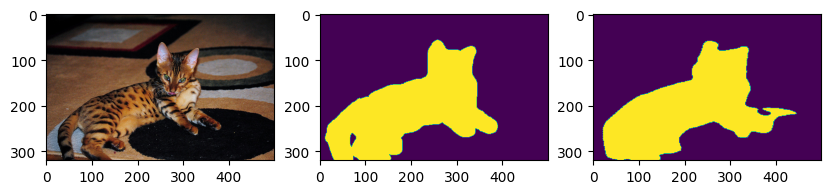

In [87]:
img = cv.imread(image_dir + '/Bengal_106.jpg')
mask = cv.imread(annotation_dir + '/Bengal_106.png', 0)

predictor = Prediction(model, weights = weights, img_size = image_size, device = device)
predicted_mask = predictor.predict(img, transform = True)

plt.figure(figsize = (10, 8))
plt.subplot(1,3,1)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1,3,2)
mask[mask == 2] = 0
mask[mask == 3] = 1
plt.imshow(mask)

plt.subplot(1,3,3)
plt.imshow(predicted_mask)

In [84]:
!wget https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-mediumSquareAt3X-v2.jpg

--2023-06-06 03:47:54--  https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-mediumSquareAt3X-v2.jpg
Resolving static01.nyt.com (static01.nyt.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to static01.nyt.com (static01.nyt.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 634575 (620K) [image/jpeg]
Saving to: ‘07CAT-STRIPES-mediumSquareAt3X-v2.jpg’

07CAT-STRIPES-mediu 100%[===================>] 619.70K  --.-KB/s    in 0.03s   

2023-06-06 03:47:54 (19.9 MB/s) - ‘07CAT-STRIPES-mediumSquareAt3X-v2.jpg’ saved [634575/634575]



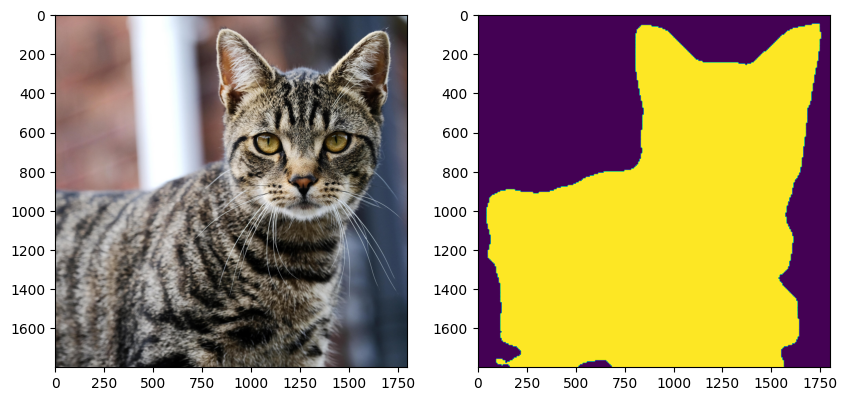

In [85]:
img = cv.imread('07CAT-STRIPES-mediumSquareAt3X-v2.jpg')

predictor = Prediction(model, weights = weights, img_size = image_size, device = device)
predicted_mask = predictor.predict(img, transform = True)

plt.figure(figsize = (10, 8))
plt.subplot(1,2,1)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(predicted_mask)